# Introduction

**This notebook has been shamelessly copied from [Josh Gordon's github repo on decision tree](https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb) and have been modified by me for regression task as well.**

Before you start please watch below video by Josh Gordon on decision trees [here](https://www.youtube.com/embed/LDRbO9a6XPU):
<iframe width="700" height="394" src="https://www.youtube.com/embed/LDRbO9a6XPU" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [530]:
# For Python 2 / 3 compatability
from __future__ import print_function
import math
from sklearn import datasets
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [75]:
# Toy dataset.
# Format: each row is an example.
# The last column is the label.
# The first two columns are features.
# Feel free to play with it by adding more features & examples.
# Interesting note: I've written this so the 2nd and 5th examples
# have the same features, but different labels - so we can see how the
# tree handles this case.
training_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]

In [76]:
# Column labels.
# These are used only to print the tree.
header = ["color", "diameter", "label"]

In [77]:
def unique_vals(rows, col):
    """Find the unique values for a column in a dataset."""
    return set([row[col] for row in rows])

In [78]:
#######
# Demo:
unique_vals(training_data, 0)
# unique_vals(training_data, 1)
#######

{'Green', 'Red', 'Yellow'}

In [79]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [80]:
#######
# Demo:
class_counts(training_data)
#######

{'Apple': 2, 'Grape': 2, 'Lemon': 1}

In [81]:
def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)

In [342]:
#######
# Demo:
is_numeric(7)
# is_numeric("Red")
#######

True

In [406]:
class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 0 for Color) and a
    'column value' (e.g., Green). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question. See the demo below.
    """

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header[self.column], condition, str(self.value))

In [407]:
#######
# Demo:
# Let's write a question for a numeric attribute
Question(1, 3)

Is diameter >= 3?

In [408]:
# How about one for a categorical attribute
q = Question(0, 'Green')
q

Is color == Green?

In [409]:
# Let's pick an example from the training set...
example = training_data[0]
# ... and see if it matches the question
q.match(example) # this will be true, since the first example is Green.
#######

True

In [347]:
def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [348]:
#######
# Demo:
# Let's partition the training data based on whether rows are Red.
true_rows, false_rows = partition(training_data, Question(0, 'Red'))
# This will contain all the 'Red' rows.
true_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]

In [349]:
# This will contain everything else.
false_rows
#######

[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

In [350]:
def gini(rows):
    """Calculate the Gini Impurity for a list of rows.

    There are a few different ways to do this, I thought this one was
    the most concise. See:
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [351]:
#######
# Demo:
# Let's look at some example to understand how Gini Impurity works.
#
# First, we'll look at a dataset with no mixing.
no_mixing = [['Apple'],
              ['Apple']]
# this will return 0
gini(no_mixing)

0.0

In [352]:
# Now, we'll look at dataset with a 50:50 apples:oranges ratio
some_mixing = [['Apple'],
               ['Orange']]
# this will return 0.5 - meaning, there's a 50% chance of misclassifying
# a random example we draw from the dataset.
gini(some_mixing)

0.5

In [353]:
# Now, we'll look at a dataset with many different labels
lots_of_mixing = [['Apple'],
                  ['Orange'],
                  ['Grape'],
                  ['Grapefruit'],
                  ['Blueberry']]
# This will return 0.8
gini(lots_of_mixing)
#######

0.7999999999999998

In [354]:
def info_gain(left, right, current_uncertainty):
    """
    Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

def mse(left, right):
    """
    Compute MSE on both the subtree (left and right)
    """
    # get the number of datapoints
    n_left = len(left)
    n_right = len(right)
    
    # mean of target on left and right split
    left_mean_score = sum([row[-1] for row in left])/ n_left
    right_mean_score = sum([row[-1] for row in right])/ n_right
    
    # compute mse of target on for left and right split
    left_mse = sum([pow(left_mean_score - row[-1], 2) for row in left])/ n_left
    right_mse = sum([pow(right_mean_score - row[-1], 2) for row in right])/ n_right
    
    # return sum of MSE
    return left_mse + right_mse

In [355]:
#######
# Demo:
# Calculate the uncertainy of our training data.
current_uncertainty = gini(training_data)
current_uncertainty

0.6399999999999999

In [356]:
# How much information do we gain by partioning on 'Green'?
true_rows, false_rows = partition(training_data, Question(0, 'Green'))
info_gain(true_rows, false_rows, current_uncertainty)

0.1399999999999999

In [357]:
# What about if we partioned on 'Red' instead?
true_rows, false_rows = partition(training_data, Question(0,'Red'))
info_gain(true_rows, false_rows, current_uncertainty)

0.37333333333333324

In [358]:
# It looks like we learned more using 'Red' (0.37), than 'Green' (0.14).
# Why? Look at the different splits that result, and see which one
# looks more 'unmixed' to you.
true_rows, false_rows = partition(training_data, Question(0,'Red'))

# Here, the true_rows contain only 'Grapes'.
true_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]

In [359]:
# And the false rows contain two types of fruit. Not too bad.
false_rows

[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

In [360]:
# On the other hand, partitioning by Green doesn't help so much.
true_rows, false_rows = partition(training_data, Question(0,'Green'))

# We've isolated one apple in the true rows.
true_rows

[['Green', 3, 'Apple']]

In [361]:
# But, the false-rows are badly mixed up.
false_rows
#######

[['Yellow', 3, 'Apple'],
 ['Red', 1, 'Grape'],
 ['Red', 1, 'Grape'],
 ['Yellow', 3, 'Lemon']]

In [362]:
def find_best_split(rows, p_type= "classification"):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    best_gain = 0  # keep track of the best information gain
    best_mse = math.inf # best error so far (the smaller the better)
    best_question = None  # keep train of the feature / value that produced it
    n_features = len(rows[0]) - 1  # number of columns
    
    # if it is a classification task, compute gini impurity
    if p_type == "classification":
        current_uncertainty = gini(rows)
        
    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value

            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            if p_type == "classification":
                gain = info_gain(true_rows, false_rows, current_uncertainty)
                # You actually can use '>' instead of '>=' here
                # but I wanted the tree to look a certain way for our
                # toy dataset.
                if gain >= best_gain:
                    best_gain, best_question = gain, question
            
            # Calculate mse this split
            else:
                mse = mse(true_rows, false_rows, current_mse)
                if mse <= best_mse:
                    best_mse = mse
                    
        # return best_gain, best_question if p_type == "classification" else best_mse, best_question
        if p_type == "classification":
            return best_gain, best_question
        else:
            return best_mse, best_question

In [363]:
a = find_best_split(training_data)
print(a)

(0.37333333333333324, Is color == Red?)


In [364]:
#######
# Demo:
# Find the best question to ask first for our toy dataset.
best_gain, best_question = find_best_split(training_data)
best_question
# FYI: is color == Red is just as good. See the note in the code above
# where I used '>='.
#######

Is color == Red?

In [412]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        self.predictions = class_counts(rows)

class LeafReg:
    """
    A Leaf node predicts data.
    It returns average of all the datapoints in the current leaf
    """

    def __init__(self, rows):
        # our predictions will be average target all the rows at leaf node
        self.predictions = sum([row[-1] for row in rows])/ len(rows)

In [505]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [531]:
def build_tree(rows, p_type= "classification", counter = 0, max_depth= 30):
    """Builds the tree.

    Rules of recursion: 1) Believe that it works. 2) Start by checking
    for the base case (no further information gain). 3) Prepare for
    giant stack traces.
    """
    

    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    # or current_depth > max_depth
    '''
    Different leaf node for classification and regression
    '''
    if (gain == 0 and p_type == "classification") :
        return Leaf(rows)
    elif gain == 0 and p_type == "regression":
        return LeafReg(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows, p_type= p_type)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows, p_type= p_type)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # dependingo on the answer.
    return Decision_Node(question, true_branch, false_branch)

In [507]:
def print_tree(node, spacing=""):
    """World's most elegant tree printing function. * Classification"""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

def print_tree_reg(node, spacing=""):
    """World's most elegant tree printing function. * Regression"""
    # Base case: we've reached a leaf
    if isinstance(node, LeafReg):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree_reg(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree_reg(node.false_branch, spacing + "  ")

# Classification Example

In [508]:
my_tree = build_tree(training_data)

In [509]:
print_tree(my_tree)

Is x == Red?
--> True:
  Predict {'Grape': 2}
--> False:
  Is x == Yellow?
  --> True:
    Predict {'Apple': 1, 'Lemon': 1}
  --> False:
    Predict {'Apple': 1}


In [510]:
def classify(row, node):
    """See the 'rules of recursion' above."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.f
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

def predict(row, node):
    """See the 'rules of recursion' above."""

    # Base case: we've reached a leaf
    if isinstance(node, LeafReg):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.f
    if node.question.match(row):
        return predict(row, node.true_branch)
    else:
        return predict(row, node.false_branch)
    
    
class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 0 for Color) and a
    'column value' (e.g., Green). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question. See the demo below.
    """

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header[self.column], condition, str(self.value))

In [511]:
#######
# Demo:
# The tree predicts the 1st row of our
# training data is an apple with confidence 1.
classify(training_data[0], my_tree)
#######

{'Apple': 1}

In [512]:
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [513]:
#######
# Demo:
# Printing that a bit nicer
print_leaf(classify(training_data[0], my_tree))
#######

{'Apple': '100%'}

In [514]:
#######
# Demo:
# On the second example, the confidence is lower
print_leaf(classify(training_data[1], my_tree))
#######

{'Apple': '50%', 'Lemon': '50%'}

In [515]:
# Evaluate
testing_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 4, 'Apple'],
    ['Red', 2, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]

In [516]:
for row in testing_data:
    print ("Actual: %s. Predicted: %s" %
           (row[-1], print_leaf(classify(row, my_tree))))

Actual: Apple. Predicted: {'Apple': '100%'}
Actual: Apple. Predicted: {'Apple': '50%', 'Lemon': '50%'}
Actual: Grape. Predicted: {'Grape': '100%'}
Actual: Grape. Predicted: {'Grape': '100%'}
Actual: Lemon. Predicted: {'Apple': '50%', 'Lemon': '50%'}


# Regression Example

In [517]:
# generating toy dataset
x, y = datasets.make_regression(n_samples=100, n_features=1, n_informative=1, noise=5, random_state= 1)
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

In [518]:
# combine features and lables into one 2d array
data = np.hstack([X_train, np.expand_dims(y_train, 1)])
data_test = np.hstack([X_test, np.expand_dims(y_test, 1)])

Text(0.5, 1.0, 'Toy linear regression dataset')

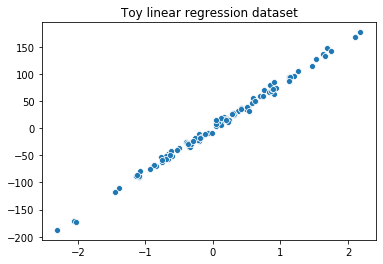

In [519]:
# visiualizing our dataset
sns.scatterplot(x[:, 0], y).set_title("Toy linear regression dataset")

In [520]:
# set the column names
header = ["x", "y"]
my_tree = build_tree(data, p_type= "regression")

In [521]:
# print_tree_reg(my_tree)

In [522]:
# for each row in test set, make prediction
for row in data_test:
    print ("Actual: %s. Predicted: %s" %(row[-1], predict(row, my_tree)))

Actual: -16.182613234884535. Predicted: -18.18887025551526
Actual: 26.09466022796643. Predicted: 25.05706329397776
Actual: -117.00095028113549. Predicted: -172.4027889081725
Actual: 71.89195915308501. Predicted: 80.08688427823328
Actual: -29.91077359578776. Predicted: -34.9051018763354
Actual: 73.48810851438917. Predicted: 63.63323786561832
Actual: 68.6566125560334. Predicted: 80.08688427823328
Actual: 85.07599704822123. Predicted: 63.63323786561832
Actual: -49.95635880438457. Predicted: -47.10421034116462
Actual: -50.916031694204186. Predicted: -42.50633703712883
Actual: -56.93218616888022. Predicted: -47.10421034116462
Actual: -27.629542428678768. Predicted: -35.18305670310365
Actual: 50.59174997785491. Predicted: 55.34407792157434
Actual: 71.80446159598674. Predicted: 80.08688427823328
Actual: 11.548262596296127. Predicted: 18.670733354404543
Actual: 128.0832930454806. Predicted: 114.75571614295292
Actual: -8.105391367162541. Predicted: -7.996226678425758
Actual: -49.86073922301242.

In [526]:
# compute train MSE
train_mse = 0
for i, row in enumerate(data):
    pred = predict(row, my_tree)
    train_mse += pow(pred - row[-1] , 2)
# finally divide the squared sum with number of datapoints
else:
    train_mse /= len(data)

# compute test MSE
test_mse = 0
for i, row in enumerate(data_test):
    pred = predict(row, my_tree)
    test_mse += pow(pred - row[-1] , 2)
# finally divide the squared sum with number of datapoints
else:
    test_mse /= len(data_test)

In [529]:
print(f"Train MSE: {train_mse}\r\nTest MSE: {test_mse}")

Train MSE: 0.0
Test MSE: 222.91637127863788


We are overfitting here but it is ok as the object is to learn and understand the concept better. Overfitting can be reduced by number of parameters like `max_depth`, `min_sample_split` etc.


To learn more please check out sklearn's documentation on decision tree [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)